Creating comparative OSMnx stats tables for neighborhood pairs. 

|       Neighborhood Pair      |             Seoul            |      Los Angeles     |
|:----------------------------:|:----------------------------:|:--------------------:|
| Highest % Commute by Transit |        Sindang 5-dong        |       Westlake       |
| Highest % Commute by Vehicle |         Geoyeo 1-dong        |        Norwalk       |
|    Highest Rail Ridership    |          Seocho-dong         |         DTLA         |
|  Highest Population Density  | Sadang 4-dong / Jungang-dong | Westlake / Koreatown |
|      Highest Job Density     |         Singil 3-dong        |    DTLA / Burbank    |

In [177]:
import pandas as pd
# for spatial data
import geopandas as gpd

# for plotting
import matplotlib.pyplot as plt

# for network analysis
import networkx as nx

# for street network analysis
import osmnx as ox

# for basemaps
import contextily as ctx

In [178]:
#COMMUTE MODE 

# Highest % commute by transit (except taxi)
s_transit = 'Sindang 5(o)-dong, Jung-gu, Seoul, 04578, South Korea'
l_transit =  'Westlake, Los Angeles, Los Angeles County, California, United States'
# Highest % commute by car
s_car = 'Geoyeo 1(il)-dong, Songpa-gu, Seoul, 05771, South Korea'
l_car = 'Norwalk, Los Angeles County, California, United States'


# RIDERSHIP 
# LRT station with the highest ridership 
s_lrt = 'Seocho-dong, Seocho-gu, Seoul, South Korea'
l_lrt = 'Downtown, Los Angeles, Los Angeles County, California, United States'
##what happens when point data is used? 
 
# DEMAND/NEED 
# Highest population density 
s_popdense = 'Jungang-dong, Seoul, South Korea'
l_popdense = 'Koreatown, Los Angeles, CA, USA'

# Highest job density
s_jobdense = 'Singil 3(sam)-dong, Yeongdeungpo-gu, Seoul, 07380, South Korea'
l_jobdense = 'Burbank, Los Angeles County, California, United States'

Creating dataframes for neighborhood pairs: 

In [179]:
places = {'Seoul': [s_transit, s_car, s_lrt, s_popdense, s_jobdense],
        'Los Angeles': [l_transit, l_car, l_lrt, l_popdense, l_jobdense]
        }
 
                
place_df_2 = pd.DataFrame(places, columns = ['Seoul','Los Angeles'], index=['Highest % Commute by Transit','Highest % Commute by Car','Highest Ridership','Population Dense', 'Job Dense'])
place_df_2 

,Seoul,Los Angeles
Highest % Commute by Transit,"Sindang 5(o)-dong, Jung-gu, Seoul, 04578, Sout...","Westlake, Los Angeles, Los Angeles County, Cal..."
Highest % Commute by Car,"Geoyeo 1(il)-dong, Songpa-gu, Seoul, 05771, So...","Norwalk, Los Angeles County, California, Unite..."
Highest Ridership,"Seocho-dong, Seocho-gu, Seoul, South Korea","Downtown, Los Angeles, Los Angeles County, Cal..."
Population Dense,"Jungang-dong, Seoul, South Korea","Koreatown, Los Angeles, CA, USA"
Job Dense,"Singil 3(sam)-dong, Yeongdeungpo-gu, Seoul, 07...","Burbank, Los Angeles County, California, Unite..."


# Call OSMnx 

###### FIGURE OUT LATER: Create dictionary to define variables for each place name 

https://stackoverflow.com/questions/52751674/how-to-use-exec-to-assign-list-to-variable-according-to-dictionary-in-python3

https://stackoverflow.com/questions/5036700/how-can-you-dynamically-create-variables-via-a-while-loop

a = {}
k = 0
while k < 10:
    <dynamically create key> 
    key = ...
    <calculate value> 
    value = ...
    a[key] = value 
    k += 1

Meanwhile I will create these maps manually. 

###### FOR EACH NEIGHBORHOOD PAIR: CHANGE THE LA_neighborhood and Seoul_neighborhood AND 'RUN ALL BELOW' 

|       Neighborhood Pair      |             Seoul            |      Los Angeles     |
|:----------------------------:|:----------------------------:|:--------------------:|
| Highest % Commute by Transit |        Sindang 5-dong        |       Westlake       |
| Highest % Commute by Vehicle |         Geoyeo 1-dong        |        Norwalk       |
|    Highest Rail Ridership    |          Seocho-dong         |         DTLA         |
|  Highest Population Density  | Sadang 4-dong / Jungang-dong | Westlake / Koreatown |
|      Highest Job Density     |         Singil 3-dong        |    DTLA / Burbank    |

In [180]:
# configure the place, network type, trip times, and travel speed
LA_n = l_popdense
Seoul_n = s_popdense
network_type = 'walk' 
distance = 1000 

In [181]:
def configure_pair (place1, place2, networktype, distance):    

# NEED TO CALL GRAPH_FROM_PLACE TO FIND CENTER NODE

    # download neighborhood street network
    global n1_place
    global n2_place
    n1_place = ox.graph_from_place(place1, network_type = networktype)
    n2_place = ox.graph_from_place(place2, network_type = networktype)
    
    # project downloaded network data to Web Mercator (measurements are in meters)
    global n1_place_crs 
    global n2_place_crs 
    n1_place_crs = ox.project_graph(n1_place, to_crs='epsg:3857') 
    n2_place_crs = ox.project_graph(n2_place, to_crs='epsg:3857')
    
    # convert nodes and edges to two separate geodataframes 
    global n1_node_place
    global n2_node_place
    global n1_edge_place
    global n2_edge_place
    n1_node_place, n1_edge_place = ox.graph_to_gdfs(n1_place_crs) 
    n2_node_place, n2_edge_place = ox.graph_to_gdfs(n2_place_crs) 
    
    # get the bounding box coordinates
    n1_minx, n1_miny, n1_maxx, n1_maxy = n1_node_place.geometry.total_bounds
    n2_minx, n2_miny, n2_maxx, n2_maxy = n2_node_place.geometry.total_bounds
    
    # calculate the centroid
    n1_centroid_x = (n1_maxx-n1_minx)/2 + n1_minx
    n1_centroid_y = (n1_maxy-n1_miny)/2 + n1_miny 

    n2_centroid_x = (n2_maxx-n2_minx)/2 + n2_minx
    n2_centroid_y = (n2_maxy-n2_miny)/2 + n2_miny 
    
    # use osmnx's get_nearest_node command to get the id for the nearest node
    global n1_center_node
    n1_center_node = ox.get_nearest_node(n1_place_crs, 
                                  (n1_centroid_y, n1_centroid_x), 
                                  method = 'euclidean') 
    global n2_center_node 
    n2_center_node = ox.get_nearest_node(n2_place_crs, 
                                  (n2_centroid_y,n2_centroid_x), 
                                  method = 'euclidean') 
    
    #NEW:
    #define a tuple for the coordinates of each neighborhood's central node 
    n1_lat = n1_place.nodes[n1_center_node]['y']
    n1_long = n1_place.nodes[n1_center_node]['x']
    n1_tuple = (n1_lat, n1_long)
    
    n2_lat = n2_place.nodes[n2_center_node]['y']
    n2_long = n2_place.nodes[n2_center_node]['x']
    n2_tuple = (n2_lat, n2_long)
    
    
# NOW THAT WE FOUND THE CENTER NODE, CALL GRAPH_FROM_POINT 
     # download neighborhood street network
    global n1_pt
    global n2_pt
    n1_pt = ox.graph.graph_from_point(n1_tuple, dist = distance, dist_type='bbox', network_type = networktype, simplify=True, retain_all=False, truncate_by_edge=False, clean_periphery=True, custom_filter=None)
    n2_pt = ox.graph.graph_from_point(n2_tuple, dist = distance, dist_type='bbox', network_type = networktype, simplify=True, retain_all=False, truncate_by_edge=False, clean_periphery=True, custom_filter=None)
    
    # project downloaded network data to Web Mercator (measurements are in meters)
    n1_pt = ox.project_graph(n1_pt, to_crs='epsg:3857') 
    n2_pt = ox.project_graph(n2_pt, to_crs='epsg:3857')
    
    # convert nodes and edges to two separate geodataframes 
    global n1_node_pt
    global n2_node_pt
    global n1_edge_pt
    global n2_edge_pt   
    n1_node_pt, n1_edge_pt = ox.graph_to_gdfs(n1_pt) 
    n2_node_pt, n2_edge_pt = ox.graph_to_gdfs(n2_pt) 
    

In [182]:
configure_pair(Seoul_n, LA_n, network_type, distance)

Map the pair! 

Text(0.5, 1.0, 'Koreatown, Los Angeles, CA, USA (walk, 1000 m from center)')

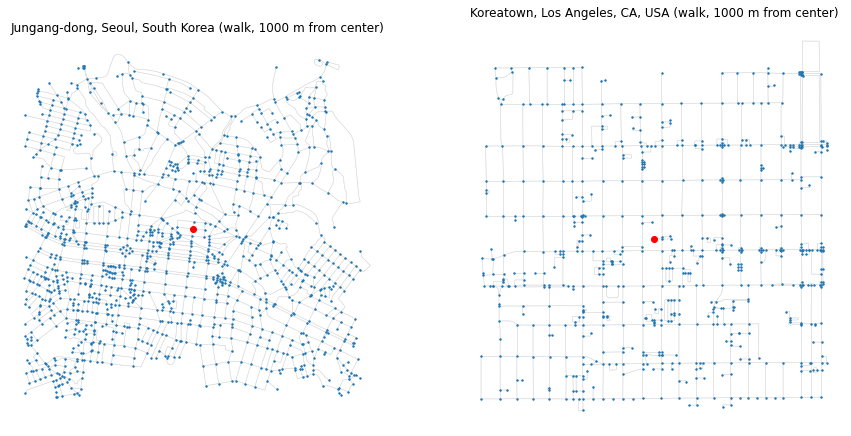

In [183]:
fig, axs = plt.subplots(1, 2, figsize=(15, 12))
ax1, ax2 = axs
    
# Neighborhood 1 
n1_edge_pt.plot(ax = ax1,
                            linewidth = 0.5, 
                            edgecolor='gainsboro',
                            zorder=10
                            )  
# add all nodes to ax
n1_node_pt.plot(ax=ax1, 
                   markersize=2, 
                   zorder=20)
    
# add the center node in red also to ax
n1_node_place.loc[[n1_center_node]].plot(ax = ax1,
                                      color='r', 
                                      zorder=30)
    
ax1.axis("off")
ax1.set_title(Seoul_n + " (" + network_type + ", " + str(distance) + " m from center)")



# Neighborhood 2 
n2_edge_pt.plot(linewidth = 0.5, 
                            edgecolor='gainsboro',
                            zorder=10,
                            ax = ax2)  
# add all nodes to ax
n2_node_pt.plot(ax=ax2, 
                   markersize=2, 
                   zorder=20)
    
# add the center node in red also to ax
n2_node_place.loc[[n2_center_node]].plot(ax=ax2,
                                      color='r', 
                                      zorder=30)

ax2.axis("off")
ax2.set_title(LA_n + " (" + network_type + ", " + str(distance) + " m from center)")


# Nodes and Edges

Neighborhood 1: 

In [184]:
print("Nodes & Edges of " + Seoul_n)
n1_node_pt.head()

Nodes & Edges of Jungang-dong, Seoul, South Korea


,y,x,osmid,highway,lon,lat,geometry
357899357,4.507675e+06,1.413260e+07,357899357,bus_stop,126.955328,37.490330,POINT (14132602.455 4507674.662)
436821642,4.507726e+06,1.413272e+07,436821642,NaN,126.956415,37.490697,POINT (14132723.471 4507726.123)
436821652,4.507989e+06,1.413273e+07,436821652,NaN,126.956474,37.492572,POINT (14132730.050 4507989.170)
436830530,4.506020e+06,1.413311e+07,436830530,NaN,126.959892,37.478535,POINT (14133110.551 4506019.919)
436848352,4.506530e+06,1.413229e+07,436848352,NaN,126.952556,37.482170,POINT (14132293.911 4506529.887)


Neighborhood 2: 

In [185]:
print("Nodes & Edges of " + LA_n)
n2_node_pt.head()

Nodes & Edges of Koreatown, Los Angeles, CA, USA


,y,x,osmid,highway,lon,lat,geometry
15855775,4.037091e+06,-1.317011e+07,15855775,traffic_signals,-118.309108,34.061706,POINT (-13170109.659 4037090.593)
60947656,4.038572e+06,-1.316845e+07,60947656,NaN,-118.294186,34.072733,POINT (-13168448.605 4038572.464)
60947657,4.038573e+06,-1.316871e+07,60947657,stop,-118.296554,34.072740,POINT (-13168712.154 4038573.404)
60947660,4.038578e+06,-1.316892e+07,60947660,NaN,-118.298422,34.072775,POINT (-13168920.132 4038578.068)
60947662,4.038578e+06,-1.316914e+07,60947662,traffic_signals,-118.300408,34.072770,POINT (-13169141.135 4038577.503)


# Street Grid Statistics  

OSMnx documentation: https://osmnx.readthedocs.io/en/stable/osmnx.html 


## basic_stats & extended_stats

In [186]:
def pair_basicstats(n1, n2, distance):
    n1_dict = ox.basic_stats(n1, area = (distance*2)**2, circuity_dist= 'euclidean')
    n2_dict = ox.basic_stats(n2, area = (distance*2)**2, circuity_dist= 'euclidean')
    
    n1_df = pd.DataFrame.from_dict(n1_dict)
    n2_df = pd.DataFrame.from_dict(n2_dict)

    print("Basic Stats for "+ n1)
    return(n1_df)
    print("Basic Stats for "+ n2)
    return(n2_df)

In [187]:
def pair_extstats(n1, n2, distance, circuitydistance):
    n1_dict = ox.stats.extended_stats(n1, connectivity=False, anc=False, ecc=False, bc=False, cc=False)
    n2_dict = ox.stats.extended_stats(n2, connectivity=False, anc=False, ecc=False, bc=False, cc=False)
    
    n1_df = pd.DataFrame.from_dict(n1_dict)
    n2_df = pd.DataFrame.from_dict(n2_dict)

    print("Extended Stats for "+ n1)
    return(n1_df)
    print("Extended Stats for "+ n2)
    return(n2_df)
 

## Basic Stats

Documentation for ox.basic_stats(): https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.stats.basic_stats

##### Seoul Neighborhood Basic Stats

In [188]:
s_basicstats_dict = ox.basic_stats(n1_pt, area = (distance*2)**2, circuity_dist='euclidean')
print("Basic Stats for "+ Seoul_n)
s_basicstats_dict

Basic Stats for Jungang-dong, Seoul, South Korea


{'n': 1230,
 'm': 3590,
 'k_avg': 5.837398373983739,
 'intersection_count': 1075,
 'streets_per_node_avg': 2.986991869918699,
 'streets_per_node_counts': {0: 0, 1: 155, 2: 0, 3: 793, 4: 270, 5: 12},
 'streets_per_node_proportion': {0: 0.0,
  1: 0.12601626016260162,
  2: 0.0,
  3: 0.6447154471544716,
  4: 0.21951219512195122,
  5: 0.00975609756097561},
 'edge_length_total': 200568.91000000027,
 'edge_length_avg': 55.86877715877445,
 'street_length_total': 100284.45499999997,
 'street_length_avg': 55.86877715877436,
 'street_segments_count': 1795,
 'node_density_km': 307.5,
 'intersection_density_km': 268.75,
 'edge_density_km': 50142.227500000066,
 'street_density_km': 25071.113749999993,
 'circuity_avg': 0.8249443474162215,
 'self_loop_proportion': 0.0022284122562674096,
 'clean_intersection_count': None,
 'clean_intersection_density_km': None}

##### LA Neighborhood Basic Stats 

In [189]:
l_basicstats_dict = ox.basic_stats(n2_pt, area = (distance*2)**2, circuity_dist='euclidean')
print("Basic Stats for "+ LA_n)
l_basicstats_dict

Basic Stats for Koreatown, Los Angeles, CA, USA


{'n': 652,
 'm': 1942,
 'k_avg': 5.957055214723926,
 'intersection_count': 569,
 'streets_per_node_avg': 3.098159509202454,
 'streets_per_node_counts': {0: 0, 1: 83, 2: 0, 3: 341, 4: 226, 5: 2},
 'streets_per_node_proportion': {0: 0.0,
  1: 0.1273006134969325,
  2: 0.0,
  3: 0.5230061349693251,
  4: 0.34662576687116564,
  5: 0.003067484662576687},
 'edge_length_total': 136950.47200000024,
 'edge_length_avg': 70.52032543769323,
 'street_length_total': 68475.23600000002,
 'street_length_avg': 70.52032543769312,
 'street_segments_count': 971,
 'node_density_km': 163.0,
 'intersection_density_km': 142.25,
 'edge_density_km': 34237.61800000006,
 'street_density_km': 17118.809000000005,
 'circuity_avg': 0.872085734143942,
 'self_loop_proportion': 0.004119464469618949,
 'clean_intersection_count': None,
 'clean_intersection_density_km': None}

Ok so what is a dict... 

From documentation: 

"The Graph class uses a dict-of-dict-of-dict data structure. The outer dict (node_dict) holds adjacency information keyed by node. The next dict (adjlist_dict) represents the adjacency information and holds edge data keyed by neighbor. The inner dict (edge_attr_dict) represents the edge data and holds edge attribute values keyed by attribute names. 
Each of these three dicts can be replaced in a subclass by a user defined dict-like object. In general, the dict-like features should be maintained but extra features can be added. To replace one of the dicts create a new graph class by changing the class(!) variable holding the factory for that dict-like structure. The variable names are node_dict_factory, node_attr_dict_factory, adjlist_inner_dict_factory, adjlist_outer_dict_factory, edge_attr_dict_factory and graph_attr_dict_factory."


Didn't quite understand, so I googled it...  

"NetworkX uses dicts to store the nodes and neighbors in a graph."

"Graph—Undirected graphs with self loops"*

Source: https://networkx.org/documentation/stable/reference/classes/index.html#basic-graph-types


Eh I'm not comfortable with dicts so I'm going to convert Westlake's network stats to a dataframe. 
Source: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.from_dict.html 


In [190]:
s_basicstats_df = pd.DataFrame.from_dict(s_basicstats_dict)
print("Basic Stats for "+ Seoul_n)
s_basicstats_df

Basic Stats for Jungang-dong, Seoul, South Korea


,n,m,k_avg,intersection_count,streets_per_node_avg,streets_per_node_counts,streets_per_node_proportion,edge_length_total,edge_length_avg,street_length_total,street_length_avg,street_segments_count,node_density_km,intersection_density_km,edge_density_km,street_density_km,circuity_avg,self_loop_proportion,clean_intersection_count,clean_intersection_density_km
0,1230,3590,5.837398,1075,2.986992,0,0.000000,200568.91,55.868777,100284.455,55.868777,1795,307.5,268.75,50142.2275,25071.11375,0.824944,0.002228,None,None
1,1230,3590,5.837398,1075,2.986992,155,0.126016,200568.91,55.868777,100284.455,55.868777,1795,307.5,268.75,50142.2275,25071.11375,0.824944,0.002228,None,None
2,1230,3590,5.837398,1075,2.986992,0,0.000000,200568.91,55.868777,100284.455,55.868777,1795,307.5,268.75,50142.2275,25071.11375,0.824944,0.002228,None,None
3,1230,3590,5.837398,1075,2.986992,793,0.644715,200568.91,55.868777,100284.455,55.868777,1795,307.5,268.75,50142.2275,25071.11375,0.824944,0.002228,None,None
4,1230,3590,5.837398,1075,2.986992,270,0.219512,200568.91,55.868777,100284.455,55.868777,1795,307.5,268.75,50142.2275,25071.11375,0.824944,0.002228,None,None
5,1230,3590,5.837398,1075,2.986992,12,0.009756,200568.91,55.868777,100284.455,55.868777,1795,307.5,268.75,50142.2275,25071.11375,0.824944,0.002228,None,None


In [191]:
l_basicstats_df = pd.DataFrame.from_dict(l_basicstats_dict)
print("Basic Stats for "+ Seoul_n)
l_basicstats_df

Basic Stats for Jungang-dong, Seoul, South Korea


,n,m,k_avg,intersection_count,streets_per_node_avg,streets_per_node_counts,streets_per_node_proportion,edge_length_total,edge_length_avg,street_length_total,street_length_avg,street_segments_count,node_density_km,intersection_density_km,edge_density_km,street_density_km,circuity_avg,self_loop_proportion,clean_intersection_count,clean_intersection_density_km
0,652,1942,5.957055,569,3.09816,0,0.000000,136950.472,70.520325,68475.236,70.520325,971,163.0,142.25,34237.618,17118.809,0.872086,0.004119,None,None
1,652,1942,5.957055,569,3.09816,83,0.127301,136950.472,70.520325,68475.236,70.520325,971,163.0,142.25,34237.618,17118.809,0.872086,0.004119,None,None
2,652,1942,5.957055,569,3.09816,0,0.000000,136950.472,70.520325,68475.236,70.520325,971,163.0,142.25,34237.618,17118.809,0.872086,0.004119,None,None
3,652,1942,5.957055,569,3.09816,341,0.523006,136950.472,70.520325,68475.236,70.520325,971,163.0,142.25,34237.618,17118.809,0.872086,0.004119,None,None
4,652,1942,5.957055,569,3.09816,226,0.346626,136950.472,70.520325,68475.236,70.520325,971,163.0,142.25,34237.618,17118.809,0.872086,0.004119,None,None
5,652,1942,5.957055,569,3.09816,2,0.003067,136950.472,70.520325,68475.236,70.520325,971,163.0,142.25,34237.618,17118.809,0.872086,0.004119,None,None


## Extended Stats

In [192]:
%%time 
s_extstats_dict = ox.stats.extended_stats(n1_pt, connectivity=True, anc=False, ecc=False, bc=False, cc=False)
print("Extended Stats for "+ Seoul_n)
s_extstats_dict

Extended Stats for Jungang-dong, Seoul, South Korea
CPU times: user 25.9 s, sys: 19.3 ms, total: 25.9 s
Wall time: 26.1 s


{'avg_neighbor_degree': {357899357: 3.0,
  436821642: 3.0,
  436821652: 3.0,
  436830530: 3.5,
  436848352: 3.5,
  436848353: 3.6666666666666665,
  436848354: 4.0,
  436848356: 3.75,
  436848358: 3.75,
  436848360: 3.75,
  436859977: 3.3333333333333335,
  436859979: 3.5,
  436859980: 3.75,
  436867651: 3.3333333333333335,
  436867652: 3.0,
  436867655: 3.3333333333333335,
  436867658: 3.6666666666666665,
  570824824: 3.0,
  570824847: 3.5,
  1834116141: 3.25,
  1834116150: 3.25,
  1834116152: 3.4,
  1834116173: 3.0,
  1834116176: 3.6666666666666665,
  1834116179: 3.25,
  1834116181: 3.3333333333333335,
  1834116182: 2.75,
  1834116183: 3.75,
  1834116184: 3.5,
  1834116185: 3.25,
  1834116189: 3.25,
  1834116194: 3.25,
  1834116206: 3.6666666666666665,
  1834116211: 3.5,
  1834116213: 3.75,
  1834116218: 3.3333333333333335,
  1834116220: 3.25,
  1834116221: 3.0,
  1834116222: 3.75,
  1834116226: 3.4,
  1834116227: 3.0,
  1834116228: 4.0,
  1834116233: 2.5,
  1834116252: 3.6666666666666

In [193]:
%%time 
s_extstats_df = pd.DataFrame.from_dict(s_extstats_dict).copy()
print("Extended Stats for "+ Seoul_n)
s_extstats_df

Extended Stats for Jungang-dong, Seoul, South Korea
CPU times: user 12.2 ms, sys: 1.03 ms, total: 13.2 ms
Wall time: 11.2 ms


,avg_neighbor_degree,avg_neighbor_degree_avg,avg_weighted_neighbor_degree,avg_weighted_neighbor_degree_avg,degree_centrality,degree_centrality_avg,clustering_coefficient,clustering_coefficient_avg,clustering_coefficient_weighted,clustering_coefficient_weighted_avg,pagerank,pagerank_max_node,pagerank_max,pagerank_min_node,pagerank_min,node_connectivity,edge_connectivity
357899357,3.000000,3.171748,0.084385,0.078489,0.004882,0.00475,0.000000,0.023686,0.000000,0.001819,0.000655,1834116226,0.002005,6421333358,0.000132,1,1
436821642,3.000000,3.171748,0.045986,0.078489,0.004882,0.00475,0.000000,0.023686,0.000000,0.001819,0.000714,1834116226,0.002005,6421333358,0.000132,1,1
436821652,3.000000,3.171748,0.015357,0.078489,0.001627,0.00475,0.000000,0.023686,0.000000,0.001819,0.000668,1834116226,0.002005,6421333358,0.000132,1,1
436830530,3.500000,3.171748,0.042137,0.078489,0.006509,0.00475,0.000000,0.023686,0.000000,0.001819,0.001271,1834116226,0.002005,6421333358,0.000132,1,1
436848352,3.500000,3.171748,0.077661,0.078489,0.006509,0.00475,0.166667,0.023686,0.009671,0.001819,0.001131,1834116226,0.002005,6421333358,0.000132,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8482977160,3.000000,3.171748,0.094554,0.078489,0.004882,0.00475,0.333333,0.023686,0.023918,0.001819,0.000650,1834116226,0.002005,6421333358,0.000132,1,1
8483289492,3.333333,3.171748,0.064124,0.078489,0.004882,0.00475,0.333333,0.023686,0.012438,0.001819,0.000816,1834116226,0.002005,6421333358,0.000132,1,1
8483289496,3.666667,3.171748,0.116650,0.078489,0.004882,0.00475,0.333333,0.023686,0.012438,0.001819,0.000509,1834116226,0.002005,6421333358,0.000132,1,1
8483534613,3.666667,3.171748,0.050950,0.078489,0.004882,0.00475,0.000000,0.023686,0.000000,0.001819,0.000753,1834116226,0.002005,6421333358,0.000132,1,1


In [194]:
%%time 
l_extstats_dict = ox.stats.extended_stats(n2_pt, connectivity=True, anc=False, ecc=False, bc=False, cc=False)
print("Extended Stats for "+ LA_n)
l_extstats_dict

Extended Stats for Koreatown, Los Angeles, CA, USA
CPU times: user 6.75 s, sys: 6.88 ms, total: 6.76 s
Wall time: 6.8 s


{'avg_neighbor_degree': {15855775: 3.5,
  60947656: 3.5,
  60947657: 3.6666666666666665,
  60947660: 3.3333333333333335,
  60947662: 3.5,
  60947664: 4.0,
  60947668: 3.25,
  122583746: 3.0,
  122583749: 3.0,
  122583753: 3.75,
  122583756: 3.25,
  122583757: 3.25,
  122583761: 3.5,
  122583764: 3.0,
  122583768: 3.3333333333333335,
  122613911: 2.6666666666666665,
  122639946: 3.0,
  122639948: 3.0,
  122639950: 2.6666666666666665,
  122639952: 2.3333333333333335,
  122639955: 2.6666666666666665,
  122639958: 2.5,
  122639960: 4.0,
  122639962: 2.75,
  122639964: 3.3333333333333335,
  122639967: 3.0,
  122639970: 2.6666666666666665,
  122639973: 2.3333333333333335,
  122639977: 2.75,
  122641780: 4.0,
  122641781: 4.0,
  122641783: 4.0,
  122641785: 4.0,
  122641787: 3.0,
  122641788: 3.25,
  122641790: 3.5,
  122641792: 3.75,
  122641794: 3.25,
  122641797: 3.25,
  122641801: 3.5,
  122641804: 3.75,
  122641805: 3.5,
  122641807: 2.5,
  122652879: 3.25,
  122652894: 3.333333333333333

In [195]:
%%time 
l_extstats_df = pd.DataFrame.from_dict(l_extstats_dict)
print("Extended Stats for "+ LA_n)
l_extstats_df 

Extended Stats for Koreatown, Los Angeles, CA, USA
CPU times: user 7.49 ms, sys: 8 µs, total: 7.5 ms
Wall time: 6.22 ms


,avg_neighbor_degree,avg_neighbor_degree_avg,avg_weighted_neighbor_degree,avg_weighted_neighbor_degree_avg,degree_centrality,degree_centrality_avg,clustering_coefficient,clustering_coefficient_avg,clustering_coefficient_weighted,clustering_coefficient_weighted_avg,pagerank,pagerank_max_node,pagerank_max,pagerank_min_node,pagerank_min,node_connectivity,edge_connectivity
15855775,3.500000,3.14839,0.028648,0.079011,0.012289,0.009151,0.0,0.080675,0.0,0.003869,0.003394,123012921,0.003787,6790583317,0.000312,1,1
60947656,3.500000,3.14839,0.014098,0.079011,0.006144,0.009151,0.0,0.080675,0.0,0.003869,0.003451,123012921,0.003787,6790583317,0.000312,1,1
60947657,3.666667,3.14839,0.031204,0.079011,0.009217,0.009151,0.0,0.080675,0.0,0.003869,0.002578,123012921,0.003787,6790583317,0.000312,1,1
60947660,3.333333,3.14839,0.028598,0.079011,0.009217,0.009151,0.0,0.080675,0.0,0.003869,0.002006,123012921,0.003787,6790583317,0.000312,1,1
60947662,3.500000,3.14839,0.026222,0.079011,0.006144,0.009151,0.0,0.080675,0.0,0.003869,0.001367,123012921,0.003787,6790583317,0.000312,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8460478111,3.000000,3.14839,0.054918,0.079011,0.003072,0.009151,0.0,0.080675,0.0,0.003869,0.000671,123012921,0.003787,6790583317,0.000312,1,1
8460503429,2.666667,3.14839,0.037608,0.079011,0.009217,0.009151,0.0,0.080675,0.0,0.003869,0.001725,123012921,0.003787,6790583317,0.000312,1,1
8460503432,3.000000,3.14839,0.075214,0.079011,0.003072,0.009151,0.0,0.080675,0.0,0.003869,0.000505,123012921,0.003787,6790583317,0.000312,1,1
8460503438,4.000000,3.14839,0.135644,0.079011,0.003072,0.009151,0.0,0.080675,0.0,0.003869,0.000416,123012921,0.003787,6790583317,0.000312,1,1


Now we have dataframes for the basic and extended stats of both LA and Seoul neighborhoods. 

# Clean_Tables Function

I feel like I want to make everything into a function??? 

Couldn't think of a way to rename the index to the neighborhood name, since the indices would differ for each. 

But I *could* create a function to:
1. take in the basic_stats or extended_stats dataframes of each neighborhood
2. drop unnecessary columns 
3. drop redundant rows 
4. concatenate 
5. transpose 

and at the end we will rename the columns.


## basic_table function

In [196]:
def basic_table (df1, df2):    
    # drop unnecessary columns
    df1_clean = df1.drop(['streets_per_node_counts', 'streets_per_node_proportion',
       'clean_intersection_count',
       'clean_intersection_density_km'], axis=1)

    df2_clean = df2.drop(['streets_per_node_counts', 'streets_per_node_proportion',
       'clean_intersection_count',
       'clean_intersection_density_km'], axis=1)
    
    # drop redundant rows 
    df1_clean = df1_clean.drop_duplicates().copy()
    df2_clean = df2_clean.drop_duplicates().copy()
    
    # concat 
    basic_frames = [df1_clean, df2_clean]
    
    global b_table 
    b_table = pd.concat(basic_frames)
    b_table = b_table.T 
    return b_table 

In [197]:
#test basic_table function 
basic_table(s_basicstats_df, l_basicstats_df)

,0,0
n,1230.000000,652.000000
m,3590.000000,1942.000000
k_avg,5.837398,5.957055
intersection_count,1075.000000,569.000000
streets_per_node_avg,2.986992,3.098160
edge_length_total,200568.910000,136950.472000
edge_length_avg,55.868777,70.520325
street_length_total,100284.455000,68475.236000
street_length_avg,55.868777,70.520325
street_segments_count,1795.000000,971.000000


## ext_table function 

In [198]:
def ext_table (df1, df2):    
    # drop unnecessary columns
    df1_clean = df1.drop(['avg_neighbor_degree',
           'avg_weighted_neighbor_degree', 
           'degree_centrality','clustering_coefficient', 'clustering_coefficient_weighted',
            'pagerank', 'pagerank_max_node',
           'pagerank_min_node'], axis=1)

    df2_clean = df2.drop(['avg_neighbor_degree',
           'avg_weighted_neighbor_degree', 
           'degree_centrality','clustering_coefficient', 'clustering_coefficient_weighted',
            'pagerank', 'pagerank_max_node',
           'pagerank_min_node'], axis=1)
    
    # drop redundant rows 
    df1_clean = df1_clean.drop_duplicates().copy()
    df2_clean = df2_clean.drop_duplicates().copy()
    
    # concat 
    ext_frames = [df1_clean, df2_clean]
    
    global ext_table 
    ext_table = pd.concat(ext_frames)
    ext_table = ext_table.T 
    return ext_table 

In [199]:
#test ext_table function 
ext_table(s_extstats_df, l_extstats_df) 

,357899357,15855775
avg_neighbor_degree_avg,3.171748,3.148390
avg_weighted_neighbor_degree_avg,0.078489,0.079011
degree_centrality_avg,0.004750,0.009151
clustering_coefficient_avg,0.023686,0.080675
clustering_coefficient_weighted_avg,0.001819,0.003869
pagerank_max,0.002005,0.003787
pagerank_min,0.000132,0.000312
node_connectivity,1.000000,1.000000
edge_connectivity,1.000000,1.000000


##### <font color='red'> DON"T CHANGE ANYTHING BELOW THIS DONT RUN AGAIN KEEP FOREVERRRRR </font>

Template for renaming tables: 

carcommute_e = ext_table.copy() 

carcommute_e.columns = [s_car, l_car]

print("Extended Stats for Car Centric Neighborhoods")

carcommute_e

****FOR EACH NEIGHBORHOOD PAIR: RUN ALL ABOVE AFTER CHANGING NEIGHBORHOODS FOR LA_n and Seoul_n ****


# Combined Tables 

From here, write unique code to rename each neighborhood pair's cleaned basic stats table and cleaned extended stats table. 

## Highest % Commute by Car

### Basic_Stats Table

In [122]:
carcommute_b = b_table.copy() 
carcommute_b

,0,0
n,738.000000,890.000000
m,2210.000000,2554.000000
k_avg,5.989160,5.739326
intersection_count,685.000000,773.000000
streets_per_node_avg,3.079946,2.969663
edge_length_total,147067.622000,161839.864000
edge_length_avg,66.546435,63.367214
street_length_total,73533.811000,80919.932000
street_length_avg,66.546435,63.367214
street_segments_count,1105.000000,1277.000000


In [124]:
carcommute_b.columns = [s_car, l_car]
print("Basic Stats for Car Centric Neighborhoods")
carcommute_b

Basic Stats for Car Centric Neighborhoods


,"Geoyeo 1(il)-dong, Songpa-gu, Seoul, 05771, South Korea","Norwalk, Los Angeles County, California, United States"
n,738.000000,890.000000
m,2210.000000,2554.000000
k_avg,5.989160,5.739326
intersection_count,685.000000,773.000000
streets_per_node_avg,3.079946,2.969663
edge_length_total,147067.622000,161839.864000
edge_length_avg,66.546435,63.367214
street_length_total,73533.811000,80919.932000
street_length_avg,66.546435,63.367214
street_segments_count,1105.000000,1277.000000


### Ext_Stats Table

In [125]:
carcommute_e = ext_table.copy() 
carcommute_e.columns = [s_car, l_car]
print("Extended Stats for Car Centric Neighborhoods")
carcommute_e

Extended Stats for Car Centric Neighborhoods


,"Geoyeo 1(il)-dong, Songpa-gu, Seoul, 05771, South Korea","Norwalk, Los Angeles County, California, United States"
avg_neighbor_degree_avg,3.147154,3.077809
avg_weighted_neighbor_degree_avg,0.060875,0.068830
degree_centrality_avg,0.008126,0.006456
clustering_coefficient_avg,0.033333,0.060936
clustering_coefficient_weighted_avg,0.004392,0.006974
pagerank_max,0.003067,0.002674
pagerank_min,0.000266,0.000190
node_connectivity,1.000000,1.000000
edge_connectivity,1.000000,1.000000


## Highest Rail Ridership 

### Basic_Stats Table

In [175]:
railride_b = b_table.copy()
railride_b.columns = [s_lrt, l_lrt]
print("Basic Stats for High Rail Ridership Neighborhoods")
railride_b

Basic Stats for High Rail Ridership Neighborhoods


,"Seocho-dong, Seocho-gu, Seoul, South Korea","Downtown, Los Angeles, Los Angeles County, California, United States"
n,937.000000,1258.000000
m,2872.000000,4156.000000
k_avg,6.130203,6.607313
intersection_count,875.000000,1161.000000
streets_per_node_avg,3.167556,3.400636
edge_length_total,183829.544000,212531.922000
edge_length_avg,64.007501,51.138576
street_length_total,91914.772000,106265.961000
street_length_avg,64.007501,51.138576
street_segments_count,1436.000000,2078.000000


### Ext_Stats Table

In [176]:
railride_e = ext_table.copy()
railride_e.columns = [s_lrt, l_lrt]
print("Extended Stats for High Rail Ridership Neighborhoods")
railride_e

Extended Stats for High Rail Ridership Neighborhoods


,"Seocho-dong, Seocho-gu, Seoul, South Korea","Downtown, Los Angeles, Los Angeles County, California, United States"
avg_neighbor_degree_avg,3.213963,3.489706
avg_weighted_neighbor_degree_avg,0.078453,0.133281
degree_centrality_avg,0.006549,0.005256
clustering_coefficient_avg,0.038349,0.026921
clustering_coefficient_weighted_avg,0.003797,0.002880
pagerank_max,0.002481,0.001760
pagerank_min,0.000167,0.000120
node_connectivity,1.000000,1.000000
edge_connectivity,1.000000,1.000000


## Highest Population Density

### Basic_Stats Table

In [200]:
popdense_b = b_table.copy()
popdense_b.columns = [s_popdense, l_popdense]
print("Basic Stats for Population Dense Neighborhoods")
popdense_b

Basic Stats for Population Dense Neighborhoods


,"Jungang-dong, Seoul, South Korea","Koreatown, Los Angeles, CA, USA"
n,1230.000000,652.000000
m,3590.000000,1942.000000
k_avg,5.837398,5.957055
intersection_count,1075.000000,569.000000
streets_per_node_avg,2.986992,3.098160
edge_length_total,200568.910000,136950.472000
edge_length_avg,55.868777,70.520325
street_length_total,100284.455000,68475.236000
street_length_avg,55.868777,70.520325
street_segments_count,1795.000000,971.000000


### Ext_Stats Table

In [201]:
popdense_e = ext_table.copy()
popdense_e.columns = [s_popdense, l_popdense]
print("Extended Stats for Population Dense Neighborhoods")
popdense_e

Extended Stats for Population Dense Neighborhoods


,"Jungang-dong, Seoul, South Korea","Koreatown, Los Angeles, CA, USA"
avg_neighbor_degree_avg,3.171748,3.148390
avg_weighted_neighbor_degree_avg,0.078489,0.079011
degree_centrality_avg,0.004750,0.009151
clustering_coefficient_avg,0.023686,0.080675
clustering_coefficient_weighted_avg,0.001819,0.003869
pagerank_max,0.002005,0.003787
pagerank_min,0.000132,0.000312
node_connectivity,1.000000,1.000000
edge_connectivity,1.000000,1.000000


## Highest Job Density

### Basic_Stats Table

In [150]:
jobdense_b = b_table.copy()
jobdense_b.columns = [s_jobdense, l_jobdense]
print("Basic Stats for Job Dense Neighborhoods")
jobdense_b

Basic Stats for Job Dense Neighborhoods


,"Singil 3(sam)-dong, Yeongdeungpo-gu, Seoul, 07380, South Korea","Burbank, Los Angeles County, California, United States"
n,1143.000000,960.000000
m,3402.000000,2800.000000
k_avg,5.952756,5.833333
intersection_count,1069.000000,844.000000
streets_per_node_avg,3.069116,3.012500
edge_length_total,195505.558000,173277.882000
edge_length_avg,57.467830,61.884958
street_length_total,97752.779000,86638.941000
street_length_avg,57.467830,61.884958
street_segments_count,1701.000000,1400.000000


### Ext_Stats Table

In [151]:
jobdense_e = ext_table.copy()
jobdense_e.columns = [s_jobdense, l_jobdense]
print("Extended Stats for Job Dense Neighborhoods")
jobdense_e

Extended Stats for Job Dense Neighborhoods


,"Singil 3(sam)-dong, Yeongdeungpo-gu, Seoul, 07380, South Korea","Burbank, Los Angeles County, California, United States"
avg_neighbor_degree_avg,3.140420,3.109097
avg_weighted_neighbor_degree_avg,0.073348,0.079773
degree_centrality_avg,0.005213,0.006083
clustering_coefficient_avg,0.037737,0.049028
clustering_coefficient_weighted_avg,0.005883,0.002312
pagerank_max,0.002402,0.003983
pagerank_min,0.000143,0.000171
node_connectivity,1.000000,1.000000
edge_connectivity,1.000000,1.000000


## Highest % Commute by Transit: Sindang 5 and Westlake

I actually ran the following code to figure out the process for configuring the basic_stats and extended_stats tables. I created the function afterwards.

### Basic_Stats

Okay first let's take a look at the basic_stats dataframes: 

In [33]:
print(Seoul_n)
display(s_basicstats_df)

print(LA_n)
display(l_basicstats_df)

Sindang 5(o)-dong, Seoul, South Korea


,n,m,k_avg,intersection_count,streets_per_node_avg,streets_per_node_counts,streets_per_node_proportion,edge_length_total,edge_length_avg,street_length_total,street_length_avg,street_segments_count,node_density_km,intersection_density_km,edge_density_km,street_density_km,circuity_avg,self_loop_proportion,clean_intersection_count,clean_intersection_density_km
0,1799,5270,5.85881,1540,3.003891,0,0.000000,252181.27,47.852233,126090.635,47.852233,2635,449.75,385.0,63045.3175,31522.65875,0.84249,0.001518,None,None
1,1799,5270,5.85881,1540,3.003891,259,0.143969,252181.27,47.852233,126090.635,47.852233,2635,449.75,385.0,63045.3175,31522.65875,0.84249,0.001518,None,None
2,1799,5270,5.85881,1540,3.003891,0,0.000000,252181.27,47.852233,126090.635,47.852233,2635,449.75,385.0,63045.3175,31522.65875,0.84249,0.001518,None,None
3,1799,5270,5.85881,1540,3.003891,1033,0.574208,252181.27,47.852233,126090.635,47.852233,2635,449.75,385.0,63045.3175,31522.65875,0.84249,0.001518,None,None
4,1799,5270,5.85881,1540,3.003891,492,0.273485,252181.27,47.852233,126090.635,47.852233,2635,449.75,385.0,63045.3175,31522.65875,0.84249,0.001518,None,None
5,1799,5270,5.85881,1540,3.003891,14,0.007782,252181.27,47.852233,126090.635,47.852233,2635,449.75,385.0,63045.3175,31522.65875,0.84249,0.001518,None,None
6,1799,5270,5.85881,1540,3.003891,0,0.000000,252181.27,47.852233,126090.635,47.852233,2635,449.75,385.0,63045.3175,31522.65875,0.84249,0.001518,None,None
7,1799,5270,5.85881,1540,3.003891,0,0.000000,252181.27,47.852233,126090.635,47.852233,2635,449.75,385.0,63045.3175,31522.65875,0.84249,0.001518,None,None
8,1799,5270,5.85881,1540,3.003891,1,0.000556,252181.27,47.852233,126090.635,47.852233,2635,449.75,385.0,63045.3175,31522.65875,0.84249,0.001518,None,None


Westlake, Los Angeles, CA, USA


,n,m,k_avg,intersection_count,streets_per_node_avg,streets_per_node_counts,streets_per_node_proportion,edge_length_total,edge_length_avg,street_length_total,street_length_avg,street_segments_count,node_density_km,intersection_density_km,edge_density_km,street_density_km,circuity_avg,self_loop_proportion,clean_intersection_count,clean_intersection_density_km
0,904,2506,5.544248,768,2.886062,0,0.000000,163040.708,65.060139,81520.354,65.060139,1253,226.0,192.0,40760.177,20380.0885,0.876442,0.005587,None,None
1,904,2506,5.544248,768,2.886062,136,0.150442,163040.708,65.060139,81520.354,65.060139,1253,226.0,192.0,40760.177,20380.0885,0.876442,0.005587,None,None
2,904,2506,5.544248,768,2.886062,0,0.000000,163040.708,65.060139,81520.354,65.060139,1253,226.0,192.0,40760.177,20380.0885,0.876442,0.005587,None,None
3,904,2506,5.544248,768,2.886062,600,0.663717,163040.708,65.060139,81520.354,65.060139,1253,226.0,192.0,40760.177,20380.0885,0.876442,0.005587,None,None
4,904,2506,5.544248,768,2.886062,167,0.184735,163040.708,65.060139,81520.354,65.060139,1253,226.0,192.0,40760.177,20380.0885,0.876442,0.005587,None,None
5,904,2506,5.544248,768,2.886062,1,0.001106,163040.708,65.060139,81520.354,65.060139,1253,226.0,192.0,40760.177,20380.0885,0.876442,0.005587,None,None


Not sure why clean_intersection_count (= number of intersections in street
network, merging complex ones into single points) and 
clean_intersection_density_km (= clean_intersection_count divided
by area in square kilometers) are empty... when the

Looks like streets per node *count* and streets per node *proportion* vary with each row. 

From OSMnx documentation: 

**Average streets per node:** Mean number of physical streets that emanate from
each node (intersections and dead-ends)

**Counts of streets per node:** A dictionary with keys = the number of streets
emanating from the node, and values = the number of nodes with this number

**Proportions of streets per node:** A dictionary, same as above, but represents a
proportion of the total, rather than raw counts

So do we want to take the average of these columns if we are interested in the count or proportion of streets:node? 

Whatever, we'll just use the average streets per node data. We feel comfortable dropping the redundant rows as well as the streets_per_node_counts and streets_per_node_proportion columns. 

##### Drop the columns that are not averages, and drop redundant rows. 


In [34]:
s_basicstats_df.columns

Index(['n', 'm', 'k_avg', 'intersection_count', 'streets_per_node_avg',
       'streets_per_node_counts', 'streets_per_node_proportion',
       'edge_length_total', 'edge_length_avg', 'street_length_total',
       'street_length_avg', 'street_segments_count', 'node_density_km',
       'intersection_density_km', 'edge_density_km', 'street_density_km',
       'circuity_avg', 'self_loop_proportion', 'clean_intersection_count',
       'clean_intersection_density_km'],
      dtype='object')

In [35]:
s_basicstats_df_clean = s_basicstats_df.drop(['streets_per_node_counts', 'streets_per_node_proportion',
       'clean_intersection_count',
       'clean_intersection_density_km'], axis=1)

l_basicstats_df_clean = l_basicstats_df.drop(['streets_per_node_counts', 'streets_per_node_proportion',
       'clean_intersection_count',
       'clean_intersection_density_km'], axis=1)

print(Seoul_n)
display(s_basicstats_df_clean)
print(LA_n)
display(l_basicstats_df_clean)

Sindang 5(o)-dong, Seoul, South Korea


,n,m,k_avg,intersection_count,streets_per_node_avg,edge_length_total,edge_length_avg,street_length_total,street_length_avg,street_segments_count,node_density_km,intersection_density_km,edge_density_km,street_density_km,circuity_avg,self_loop_proportion
0,1799,5270,5.85881,1540,3.003891,252181.27,47.852233,126090.635,47.852233,2635,449.75,385.0,63045.3175,31522.65875,0.84249,0.001518
1,1799,5270,5.85881,1540,3.003891,252181.27,47.852233,126090.635,47.852233,2635,449.75,385.0,63045.3175,31522.65875,0.84249,0.001518
2,1799,5270,5.85881,1540,3.003891,252181.27,47.852233,126090.635,47.852233,2635,449.75,385.0,63045.3175,31522.65875,0.84249,0.001518
3,1799,5270,5.85881,1540,3.003891,252181.27,47.852233,126090.635,47.852233,2635,449.75,385.0,63045.3175,31522.65875,0.84249,0.001518
4,1799,5270,5.85881,1540,3.003891,252181.27,47.852233,126090.635,47.852233,2635,449.75,385.0,63045.3175,31522.65875,0.84249,0.001518
5,1799,5270,5.85881,1540,3.003891,252181.27,47.852233,126090.635,47.852233,2635,449.75,385.0,63045.3175,31522.65875,0.84249,0.001518
6,1799,5270,5.85881,1540,3.003891,252181.27,47.852233,126090.635,47.852233,2635,449.75,385.0,63045.3175,31522.65875,0.84249,0.001518
7,1799,5270,5.85881,1540,3.003891,252181.27,47.852233,126090.635,47.852233,2635,449.75,385.0,63045.3175,31522.65875,0.84249,0.001518
8,1799,5270,5.85881,1540,3.003891,252181.27,47.852233,126090.635,47.852233,2635,449.75,385.0,63045.3175,31522.65875,0.84249,0.001518


Westlake, Los Angeles, CA, USA


,n,m,k_avg,intersection_count,streets_per_node_avg,edge_length_total,edge_length_avg,street_length_total,street_length_avg,street_segments_count,node_density_km,intersection_density_km,edge_density_km,street_density_km,circuity_avg,self_loop_proportion
0,904,2506,5.544248,768,2.886062,163040.708,65.060139,81520.354,65.060139,1253,226.0,192.0,40760.177,20380.0885,0.876442,0.005587
1,904,2506,5.544248,768,2.886062,163040.708,65.060139,81520.354,65.060139,1253,226.0,192.0,40760.177,20380.0885,0.876442,0.005587
2,904,2506,5.544248,768,2.886062,163040.708,65.060139,81520.354,65.060139,1253,226.0,192.0,40760.177,20380.0885,0.876442,0.005587
3,904,2506,5.544248,768,2.886062,163040.708,65.060139,81520.354,65.060139,1253,226.0,192.0,40760.177,20380.0885,0.876442,0.005587
4,904,2506,5.544248,768,2.886062,163040.708,65.060139,81520.354,65.060139,1253,226.0,192.0,40760.177,20380.0885,0.876442,0.005587
5,904,2506,5.544248,768,2.886062,163040.708,65.060139,81520.354,65.060139,1253,226.0,192.0,40760.177,20380.0885,0.876442,0.005587


##### Drop the redundant rows

1. Seoul 

In [36]:
s_basicstats_df_clean = s_basicstats_df_clean.drop([1,2,3,4,5,6,7,8]).copy()
s_basicstats_df_clean

,n,m,k_avg,intersection_count,streets_per_node_avg,edge_length_total,edge_length_avg,street_length_total,street_length_avg,street_segments_count,node_density_km,intersection_density_km,edge_density_km,street_density_km,circuity_avg,self_loop_proportion
0,1799,5270,5.85881,1540,3.003891,252181.27,47.852233,126090.635,47.852233,2635,449.75,385.0,63045.3175,31522.65875,0.84249,0.001518


2. LA 

In [37]:
l_basicstats_df_clean = l_basicstats_df_clean.drop([1,2,3,4,5]).copy()
l_basicstats_df_clean

,n,m,k_avg,intersection_count,streets_per_node_avg,edge_length_total,edge_length_avg,street_length_total,street_length_avg,street_segments_count,node_density_km,intersection_density_km,edge_density_km,street_density_km,circuity_avg,self_loop_proportion
0,904,2506,5.544248,768,2.886062,163040.708,65.060139,81520.354,65.060139,1253,226.0,192.0,40760.177,20380.0885,0.876442,0.005587


In [38]:
l_basicstats_df_clean

,n,m,k_avg,intersection_count,streets_per_node_avg,edge_length_total,edge_length_avg,street_length_total,street_length_avg,street_segments_count,node_density_km,intersection_density_km,edge_density_km,street_density_km,circuity_avg,self_loop_proportion
0,904,2506,5.544248,768,2.886062,163040.708,65.060139,81520.354,65.060139,1253,226.0,192.0,40760.177,20380.0885,0.876442,0.005587


In [39]:
s_basicstats_df_clean

,n,m,k_avg,intersection_count,streets_per_node_avg,edge_length_total,edge_length_avg,street_length_total,street_length_avg,street_segments_count,node_density_km,intersection_density_km,edge_density_km,street_density_km,circuity_avg,self_loop_proportion
0,1799,5270,5.85881,1540,3.003891,252181.27,47.852233,126090.635,47.852233,2635,449.75,385.0,63045.3175,31522.65875,0.84249,0.001518


##### Add together 
Now I'm going to add the LA values as the 2nd row (index = 1) to the Seoul dataframe: 

In [40]:
frames = [s_basicstats_df_clean, l_basicstats_df_clean]
compare_stats = pd.concat(frames)
compare_stats

,n,m,k_avg,intersection_count,streets_per_node_avg,edge_length_total,edge_length_avg,street_length_total,street_length_avg,street_segments_count,node_density_km,intersection_density_km,edge_density_km,street_density_km,circuity_avg,self_loop_proportion
0,1799,5270,5.858810,1540,3.003891,252181.270,47.852233,126090.635,47.852233,2635,449.75,385.0,63045.3175,31522.65875,0.842490,0.001518
0,904,2506,5.544248,768,2.886062,163040.708,65.060139,81520.354,65.060139,1253,226.00,192.0,40760.1770,20380.08850,0.876442,0.005587


Source: https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html 

##### Rename indices

Renaming the index for the City name: 

In [41]:
compare_stats_test = compare_stats.rename(index={0: Seoul_n, 1:LA_n})
compare_stats_test

,n,m,k_avg,intersection_count,streets_per_node_avg,edge_length_total,edge_length_avg,street_length_total,street_length_avg,street_segments_count,node_density_km,intersection_density_km,edge_density_km,street_density_km,circuity_avg,self_loop_proportion
"Sindang 5(o)-dong, Seoul, South Korea",1799,5270,5.858810,1540,3.003891,252181.270,47.852233,126090.635,47.852233,2635,449.75,385.0,63045.3175,31522.65875,0.842490,0.001518
"Sindang 5(o)-dong, Seoul, South Korea",904,2506,5.544248,768,2.886062,163040.708,65.060139,81520.354,65.060139,1253,226.00,192.0,40760.1770,20380.08850,0.876442,0.005587


##### Transpose

Alright finally I want to switch the columns and rows for this graph so it fits onto our slides. 

The transpose function does change all values to objects though, which may cause problems in the future? 
Source: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.transpose.html 

In [42]:
compare_stats_t = compare_stats_test.T
compare_stats_t

,"Sindang 5(o)-dong, Seoul, South Korea","Sindang 5(o)-dong, Seoul, South Korea"
n,1799.000000,904.000000
m,5270.000000,2506.000000
k_avg,5.858810,5.544248
intersection_count,1540.000000,768.000000
streets_per_node_avg,3.003891,2.886062
edge_length_total,252181.270000,163040.708000
edge_length_avg,47.852233,65.060139
street_length_total,126090.635000,81520.354000
street_length_avg,47.852233,65.060139
street_segments_count,2635.000000,1253.000000


Source: https://note.nkmk.me/en/python-pandas-dataframe-rename/#:~:text=source%3A%20pandas_dataframe_rename.py-,Rename%20column%20%2F%20index%3A%20rename(),change%20column%20%2F%20index%20name%20individually.&text=Specify%20the%20original%20name%20and,index%20is%20for%20index%20name.

I may want to change column names later, but will hold off till Shinah and I decide which stats to keep. 
OSMnx basic_stats documentation: https://osmnx.readthedocs.io/en/stable/osmnx.html 
list(compare_stats_test)
compare_stats_test.columns =

### Extended_Stats

In [45]:
print(Seoul_n)
display(s_extstats_df)

print(LA_n)
display(l_extstats_df)

Sindang 5(o)-dong, Seoul, South Korea


,avg_neighbor_degree,avg_neighbor_degree_avg,avg_weighted_neighbor_degree,avg_weighted_neighbor_degree_avg,degree_centrality,degree_centrality_avg,clustering_coefficient,clustering_coefficient_avg,clustering_coefficient_weighted,clustering_coefficient_weighted_avg,pagerank,pagerank_max_node,pagerank_max,pagerank_min_node,pagerank_min,node_connectivity,edge_connectivity
414685876,4.000000,3.214476,0.199384,0.122361,0.004449,0.003259,0.000000,0.02924,0.000000,0.001554,0.000491,2858053233,0.00204,8481495951,0.000097,1,1
436827118,2.750000,3.214476,0.023542,0.122361,0.004449,0.003259,0.166667,0.02924,0.004726,0.001554,0.001028,2858053233,0.00204,8481495951,0.000097,1,1
436827125,3.000000,3.214476,0.028908,0.122361,0.003337,0.003259,0.000000,0.02924,0.000000,0.001554,0.000804,2858053233,0.00204,8481495951,0.000097,1,1
436827127,3.000000,3.214476,0.025274,0.122361,0.003337,0.003259,0.000000,0.02924,0.000000,0.001554,0.000871,2858053233,0.00204,8481495951,0.000097,1,1
436827130,3.000000,3.214476,0.063693,0.122361,0.003337,0.003259,0.000000,0.02924,0.000000,0.001554,0.000509,2858053233,0.00204,8481495951,0.000097,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8508576418,3.000000,3.214476,0.008774,0.122361,0.001112,0.003259,0.000000,0.02924,0.000000,0.001554,0.000407,2858053233,0.00204,8481495951,0.000097,1,1
8508576420,2.333333,3.214476,0.013976,0.122361,0.003337,0.003259,0.333333,0.02924,0.033191,0.001554,0.000557,2858053233,0.00204,8481495951,0.000097,1,1
8508576424,3.000000,3.214476,0.012988,0.122361,0.003337,0.003259,0.333333,0.02924,0.033191,0.001554,0.000749,2858053233,0.00204,8481495951,0.000097,1,1
8509753483,3.666667,3.214476,0.069107,0.122361,0.003337,0.003259,0.333333,0.02924,0.013840,0.001554,0.000604,2858053233,0.00204,8481495951,0.000097,1,1


Westlake, Los Angeles, CA, USA


,avg_neighbor_degree,avg_neighbor_degree_avg,avg_weighted_neighbor_degree,avg_weighted_neighbor_degree_avg,degree_centrality,degree_centrality_avg,clustering_coefficient,clustering_coefficient_avg,clustering_coefficient_weighted,clustering_coefficient_weighted_avg,pagerank,pagerank_max_node,pagerank_max,pagerank_min_node,pagerank_min,node_connectivity,edge_connectivity
18166944,3.500000,2.991962,0.030830,0.067393,0.008859,0.00614,0.000000,0.036799,0.000000,0.002812,0.002029,122592367,0.002637,2118274656,0.000213,1,1
21300247,3.000000,2.991962,0.094684,0.067393,0.008859,0.00614,0.166667,0.036799,0.019494,0.002812,0.000773,122592367,0.002637,2118274656,0.000213,1,1
21300249,3.500000,2.991962,0.031206,0.067393,0.004430,0.00614,0.000000,0.036799,0.000000,0.002812,0.001083,122592367,0.002637,2118274656,0.000213,1,1
21306066,3.500000,2.991962,0.038870,0.067393,0.008859,0.00614,0.000000,0.036799,0.000000,0.002812,0.001965,122592367,0.002637,2118274656,0.000213,1,1
21306068,3.250000,2.991962,0.037148,0.067393,0.008859,0.00614,0.000000,0.036799,0.000000,0.002812,0.001747,122592367,0.002637,2118274656,0.000213,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8460152014,3.000000,2.991962,0.113188,0.067393,0.006645,0.00614,0.000000,0.036799,0.000000,0.002812,0.000783,122592367,0.002637,2118274656,0.000213,1,1
8460152015,3.000000,2.991962,0.112580,0.067393,0.006645,0.00614,0.000000,0.036799,0.000000,0.002812,0.000816,122592367,0.002637,2118274656,0.000213,1,1
8460152016,3.333333,2.991962,0.131907,0.067393,0.006645,0.00614,0.000000,0.036799,0.000000,0.002812,0.000791,122592367,0.002637,2118274656,0.000213,1,1
8460159517,2.666667,2.991962,0.035285,0.067393,0.006645,0.00614,0.000000,0.036799,0.000000,0.002812,0.001761,122592367,0.002637,2118274656,0.000213,1,1


##### Drop unneeded columns

In [46]:
s_extstats_df.columns

Index(['avg_neighbor_degree', 'avg_neighbor_degree_avg',
       'avg_weighted_neighbor_degree', 'avg_weighted_neighbor_degree_avg',
       'degree_centrality', 'degree_centrality_avg', 'clustering_coefficient',
       'clustering_coefficient_avg', 'clustering_coefficient_weighted',
       'clustering_coefficient_weighted_avg', 'pagerank', 'pagerank_max_node',
       'pagerank_max', 'pagerank_min_node', 'pagerank_min',
       'node_connectivity', 'edge_connectivity'],
      dtype='object')

In [47]:
s_extstats_clean = s_extstats_df.drop(['avg_neighbor_degree',
       'avg_weighted_neighbor_degree', 
       'degree_centrality','clustering_coefficient', 'clustering_coefficient_weighted',
        'pagerank', 'pagerank_max_node',
       'pagerank_min_node'], axis=1)

l_extstats_clean = l_extstats_df.drop(['avg_neighbor_degree',
       'avg_weighted_neighbor_degree', 
       'degree_centrality','clustering_coefficient', 'clustering_coefficient_weighted',
        'pagerank', 'pagerank_max_node',
       'pagerank_min_node'], axis=1)

print(Seoul_n)
display(s_extstats_clean)
print(LA_n)
display(l_extstats_clean)

Sindang 5(o)-dong, Seoul, South Korea


,avg_neighbor_degree_avg,avg_weighted_neighbor_degree_avg,degree_centrality_avg,clustering_coefficient_avg,clustering_coefficient_weighted_avg,pagerank_max,pagerank_min,node_connectivity,edge_connectivity
414685876,3.214476,0.122361,0.003259,0.02924,0.001554,0.00204,0.000097,1,1
436827118,3.214476,0.122361,0.003259,0.02924,0.001554,0.00204,0.000097,1,1
436827125,3.214476,0.122361,0.003259,0.02924,0.001554,0.00204,0.000097,1,1
436827127,3.214476,0.122361,0.003259,0.02924,0.001554,0.00204,0.000097,1,1
436827130,3.214476,0.122361,0.003259,0.02924,0.001554,0.00204,0.000097,1,1
...,...,...,...,...,...,...,...,...,...
8508576418,3.214476,0.122361,0.003259,0.02924,0.001554,0.00204,0.000097,1,1
8508576420,3.214476,0.122361,0.003259,0.02924,0.001554,0.00204,0.000097,1,1
8508576424,3.214476,0.122361,0.003259,0.02924,0.001554,0.00204,0.000097,1,1
8509753483,3.214476,0.122361,0.003259,0.02924,0.001554,0.00204,0.000097,1,1


Westlake, Los Angeles, CA, USA


,avg_neighbor_degree_avg,avg_weighted_neighbor_degree_avg,degree_centrality_avg,clustering_coefficient_avg,clustering_coefficient_weighted_avg,pagerank_max,pagerank_min,node_connectivity,edge_connectivity
18166944,2.991962,0.067393,0.00614,0.036799,0.002812,0.002637,0.000213,1,1
21300247,2.991962,0.067393,0.00614,0.036799,0.002812,0.002637,0.000213,1,1
21300249,2.991962,0.067393,0.00614,0.036799,0.002812,0.002637,0.000213,1,1
21306066,2.991962,0.067393,0.00614,0.036799,0.002812,0.002637,0.000213,1,1
21306068,2.991962,0.067393,0.00614,0.036799,0.002812,0.002637,0.000213,1,1
...,...,...,...,...,...,...,...,...,...
8460152014,2.991962,0.067393,0.00614,0.036799,0.002812,0.002637,0.000213,1,1
8460152015,2.991962,0.067393,0.00614,0.036799,0.002812,0.002637,0.000213,1,1
8460152016,2.991962,0.067393,0.00614,0.036799,0.002812,0.002637,0.000213,1,1
8460159517,2.991962,0.067393,0.00614,0.036799,0.002812,0.002637,0.000213,1,1


##### Drop the redundant rows

In [50]:
s_extstats_clean = s_extstats_clean.drop_duplicates().copy()
l_extstats_clean = l_extstats_clean.drop_duplicates().copy()
print(Seoul_n)
display(s_extstats_clean)
print(LA_n)
display(l_extstats_clean)

Sindang 5(o)-dong, Seoul, South Korea


,avg_neighbor_degree_avg,avg_weighted_neighbor_degree_avg,degree_centrality_avg,clustering_coefficient_avg,clustering_coefficient_weighted_avg,pagerank_max,pagerank_min,node_connectivity,edge_connectivity
414685876,3.214476,0.122361,0.003259,0.02924,0.001554,0.00204,0.000097,1,1


Westlake, Los Angeles, CA, USA


,avg_neighbor_degree_avg,avg_weighted_neighbor_degree_avg,degree_centrality_avg,clustering_coefficient_avg,clustering_coefficient_weighted_avg,pagerank_max,pagerank_min,node_connectivity,edge_connectivity
18166944,2.991962,0.067393,0.00614,0.036799,0.002812,0.002637,0.000213,1,1


##### Add together 

Now I'm going to add the LA values as the 2nd row (index = 1) to the Seoul dataframe: 

In [52]:
frames_ext = [s_extstats_clean, l_extstats_clean]
compare_extstats = pd.concat(frames_ext)
compare_extstats

,avg_neighbor_degree_avg,avg_weighted_neighbor_degree_avg,degree_centrality_avg,clustering_coefficient_avg,clustering_coefficient_weighted_avg,pagerank_max,pagerank_min,node_connectivity,edge_connectivity
414685876,3.214476,0.122361,0.003259,0.029240,0.001554,0.002040,0.000097,1,1
18166944,2.991962,0.067393,0.006140,0.036799,0.002812,0.002637,0.000213,1,1


##### Rename indices 

In [55]:
compare_extstats_test = compare_extstats.rename(index={414685876: Seoul_n, 18166944:LA_n})
compare_extstats_test

,avg_neighbor_degree_avg,avg_weighted_neighbor_degree_avg,degree_centrality_avg,clustering_coefficient_avg,clustering_coefficient_weighted_avg,pagerank_max,pagerank_min,node_connectivity,edge_connectivity
"Sindang 5(o)-dong, Seoul, South Korea",3.214476,0.122361,0.003259,0.029240,0.001554,0.002040,0.000097,1,1
"Westlake, Los Angeles, CA, USA",2.991962,0.067393,0.006140,0.036799,0.002812,0.002637,0.000213,1,1


##### Transpose

In [56]:
compare_extstats_t = compare_extstats_test.T
compare_extstats_t

,"Sindang 5(o)-dong, Seoul, South Korea","Westlake, Los Angeles, CA, USA"
avg_neighbor_degree_avg,3.214476,2.991962
avg_weighted_neighbor_degree_avg,0.122361,0.067393
degree_centrality_avg,0.003259,0.006140
clustering_coefficient_avg,0.029240,0.036799
clustering_coefficient_weighted_avg,0.001554,0.002812
pagerank_max,0.002040,0.002637
pagerank_min,0.000097,0.000213
node_connectivity,1.000000,1.000000
edge_connectivity,1.000000,1.000000
